### VAE 

This notebook is a simple implementation of a Variational Autoencoder (VAE) using PyTorch. The VAE is a generative model that learns to encode and decode data. The model is trained on Anime Face dataset. 

In [58]:
import os
import time
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model, Sequential
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, LeakyReLU, BatchNormalization, Activation, Dropout, Rescaling
from keras.optimizers import Adam
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [12]:
img_height, img_width = 256, 256
batch_size = 128

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(    
    "../data/anime_face/images",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode=None,
)

Found 63565 files belonging to 1 classes.


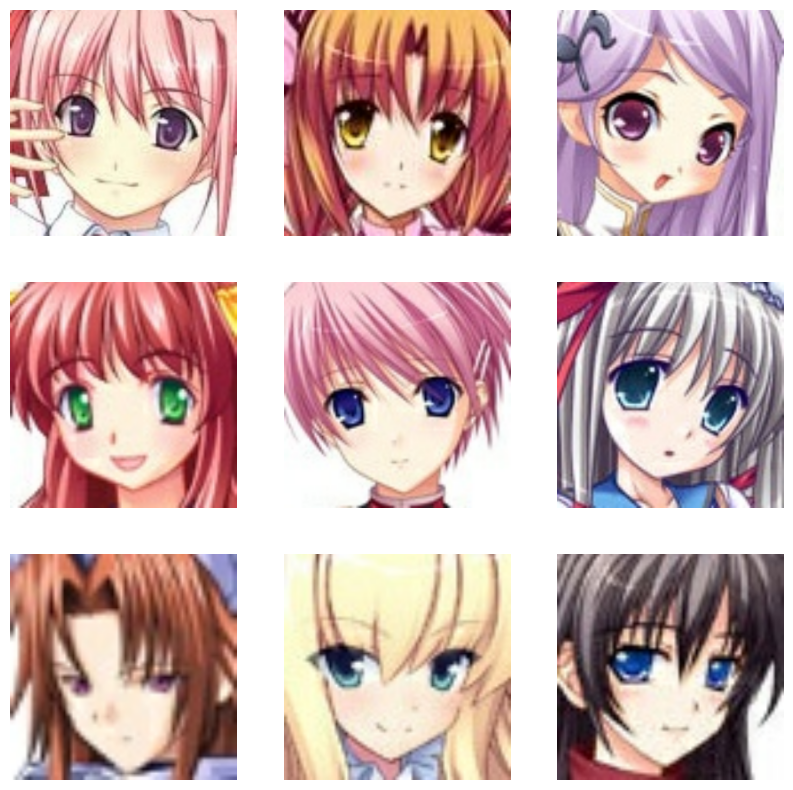

In [14]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [49]:
normalization_layer = Rescaling(scale= 1./255)
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))

In [50]:
first_image = image_batch[0]
np.min(first_image), np.max(first_image)

(0.0, 1.0)

In [51]:
HIDDEN_SIZE = 200
input_encoder = tuple(first_image.shape)
input_decoder = (HIDDEN_SIZE,)

In [52]:
def encoder(input_encoder):
    
    # inputs = keras.Input(shape=input_encoder, name="input_layer")

    # x = Conv2D(128, kernel_size=3, strides=2, padding="same")(inputs)
    # x = BatchNormalization()(x)
    # x = LeakyReLU()(x)

    # x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    # x = BatchNormalization()(x)
    # x = LeakyReLU()(x)
    # x = Dropout(0.2)(x)

    # x = Conv2D(64, 3, 2, padding="same")(x)
    # x = BatchNormalization()(x)
    # x = LeakyReLU()(x)

    # x = Conv2D(32, 3, 2, padding="same")(x)
    # x = BatchNormalization()(x)
    # x = LeakyReLU()(x)

    # flatten = Flatten()(x)
    
    # mean = Dense(HIDDEN_SIZE)(flatten)
    # log_var = Dense(HIDDEN_SIZE)(flatten)
    
    # model = Model(inputs, (mean, log_var))
    
    model = Sequential([
        Conv2D(128, kernel_size=3, strides=2, padding="same", input_shape=input_encoder),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2D(64, kernel_size=3, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.2),
        
        Conv2D(64, 3, 2, padding="same"),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2D(32, 3, 2, padding="same"),
        BatchNormalization(),
        LeakyReLU(),
        
        Flatten(),
        
        Dense(HIDDEN_SIZE),
        
        Dense(HIDDEN_SIZE)
    ])

    return model

In [53]:
enc = encoder(input_encoder)
enc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 128)    512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0

In [54]:
def sampling_model(args):
    mean, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean), mean=0.0, stddev=1.0)
    return mean + K.exp(log_var / 2) * epsilon


def sampling(input_1, input_2):
    mean = Input(shape=input_1)
    log_var = Input(shape=input_2)
    out = layers.Lambda(sampling_model)([mean, log_var])
    enc_2 = Model([mean, log_var], out)
    return enc_2

In [ ]:
sample = sampling(input_decoder, input_decoder)
sample.save("../models/sample_model_for_anime_faces.h5")

In [56]:
def decoder(input_decoder):

    # inputs = Input(shape=input_decoder)
    # x = Dense(4096)(inputs)
    # x = Reshape((8, 8, 64))(x)

    # x = Conv2DTranspose(32, 3, strides=2, padding="same")(x)
    # x = BatchNormalization()(x)
    # x = LeakyReLU()(x)

    # x = Conv2DTranspose(64, 3, strides=2, padding="same")(x)
    # x = BatchNormalization()(x)
    # x = LeakyReLU()(x)

    # x = Conv2DTranspose(64, 3, 2, padding="same")(x)
    # x = BatchNormalization()(x)
    # x = LeakyReLU()(x)

    # x = Conv2DTranspose(128, 3, 2, padding="same")(x)
    # x = BatchNormalization()(x)
    # x = LeakyReLU()(x)

    # outputs = Conv2DTranspose(3, 3, 2, padding="same", activation="sigmoid")(x)
    
    # model = Model(inputs, outputs)
    
    model = Sequential([
        Dense(4096, input_shape=input_decoder),
        Reshape((8, 8, 64)),
        
        Conv2DTranspose(32, 3, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2DTranspose(64, 3, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2DTranspose(64, 3, 2, padding="same"),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2DTranspose(128, 3, 2, padding="same"),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2DTranspose(3, 3, 2, padding="same", activation="sigmoid")
    ])
    
    return model

In [57]:
dec = decoder(input_decoder)
dec.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              823296    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 32)       18464     
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)      

In [59]:
adam = Adam(learning_rate=0.0001)

In [60]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])
    return 1000 * r_loss

In [61]:
def kl_loss(mean, log_var):
    kl_loss_ = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=1)
    return kl_loss_

In [62]:
def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss_ = kl_loss(mean, log_var)
    return r_loss + kl_loss_

In [67]:
@tf.function
def train_step(images):
    
    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
        
        mean, log_var = enc(images, training=True)
        z = sample([mean, log_var], training=True)
        outputs = dec(z, training=True)
        
        loss = vae_loss(images, outputs, mean, log_var)
        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    adam.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    adam.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    
    return loss

In [68]:
def generate_and_save_images(epoch, test_input):
    mean, log_var = enc(test_input, training=False)
    z = sample([mean, log_var], training=False)
    predictions = dec(z, training=False)
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i + 1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)
        pred = pred.astype(np.uint8)
        plt.imshow(pred)
        plt.axis("off")
        
    plt.savefig("../images/image_at_epoch_{:d}.png".format(epoch))
    plt.show()

In [69]:
def train(train_ds, epochs):
    
    for epoch in range(epochs):
        
        total_loss = []
        
        for images in train_ds:
            loss = train_step(images)
            total_loss.append(loss)
            
            seed = images[:25] # 25 images
            generate_and_save_images(epoch + 1, seed)   
            
            
        # seed = tf.random.normal([25, HIDDEN_SIZE])
        print("Epoch: {:d}, Loss: {:.3f}".format(epoch + 1, np.mean(total_loss)))
        
        if (epoch + 1) % 10 == 0:
            enc.save("../models/encoder_model_for_anime_faces.h5")
            dec.save("../models/decoder_model_for_anime_faces.h5")
            
    enc.save("../models/encoder_model_for_anime_faces.h5")
    dec.save("../models/decoder_model_for_anime_faces.h5")

In [ ]:
train(normalized_ds, 100)